# Pneumonia Detection with PyTorch & ResNet18

## Imports

In [21]:
import os
import re
import copy
import random
from pathlib import Path

import kagglehub
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import ResNet18_Weights, resnet18

## Setup

In [3]:
SEED = 42
EPOCHS = 20
BATCH_SIZE = 32
LR = 1e-4
PATIENCE = 5
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
TARGET_SENSITIVITY = 0.95

MODEL_DIR = Path("./models")


def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if hasattr(torch.backends, "cudnn"):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def resolve_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


seed_everything(SEED)
device = resolve_device()
print(f"Using device: {device}")

Using device: cuda


## Dataset

In [4]:
# Download data in Colab
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
raw_data_dir = Path(path) / "chest_xray" / "chest_xray"
RAW_DATA_DIR = raw_data_dir
print(f"Resolved RAW_DATA_DIR: {RAW_DATA_DIR}")

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Resolved RAW_DATA_DIR: /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray


In [5]:
def parse_patient_id(file_name: str, label: str) -> str:
    stem = Path(file_name).stem
    if label == "PNEUMONIA":
        m = re.match(r"^(person\d+)", stem)
        return m.group(1) if m else stem

    m = re.match(r"^(NORMAL2-IM-\d+|IM-\d+)", stem)
    return m.group(1) if m else stem


def parse_pneumonia_type(file_name: str, label: str) -> str:
    if label != "PNEUMONIA":
        return "none"
    lower_name = file_name.lower()
    if "_bacteria_" in lower_name:
        return "bacteria"
    if "_virus_" in lower_name:
        return "virus"
    return "unknown"


def discover_records(raw_data_dir: Path):
    records = []
    for split in ["train", "val", "test"]:
        for label in ["NORMAL", "PNEUMONIA"]:
            class_dir = raw_data_dir / split / label
            for img_path in sorted(class_dir.iterdir()):
                if not img_path.is_file() or img_path.name.startswith("."):
                    continue
                patient_id = parse_patient_id(img_path.name, label)
                pneumonia_type = parse_pneumonia_type(img_path.name, label)
                records.append(
                    {
                        "image_path": str(img_path),
                        "label": label,
                        "label_idx": 0 if label == "NORMAL" else 1,
                        "patient_id": patient_id,
                        "pneumonia_type": pneumonia_type,
                        "original_split": split,
                        "group_key": (label, patient_id),
                    }
                )
    records.sort(key=lambda r: (r["label"], r["patient_id"], r["image_path"]))
    return records


def overlap_counts_by_split(records):
    split_ids = {
        split: {
            r["patient_id"]
            for r in records
            if r["original_split"] == split and r["label"] == "PNEUMONIA"
        }
        for split in ["train", "val", "test"]
    }
    return {
        "train_val": len(split_ids["train"] & split_ids["val"]),
        "train_test": len(split_ids["train"] & split_ids["test"]),
        "val_test": len(split_ids["val"] & split_ids["test"]),
    }, split_ids


def split_bucket(keys, ratios, rng):
    keys = list(keys)
    rng.shuffle(keys)
    n = len(keys)
    if n == 0:
        return set(), set(), set()
    if n == 1:
        return set(keys), set(), set()
    if n == 2:
        return {keys[0]}, {keys[1]}, set()

    train_ratio, val_ratio, test_ratio = ratios
    n_test = max(1, int(round(n * test_ratio)))
    n_val = max(1, int(round(n * val_ratio)))

    # Keep at least one train patient.
    while n_test + n_val > n - 1:
        if n_test >= n_val and n_test > 1:
            n_test -= 1
        elif n_val > 1:
            n_val -= 1
        else:
            break

    n_train = n - n_val - n_test
    train_keys = set(keys[:n_train])
    val_keys = set(keys[n_train : n_train + n_val])
    test_keys = set(keys[n_train + n_val :])
    return train_keys, val_keys, test_keys


def split_by_patient(records, ratios=(0.8, 0.1, 0.1), seed=42):
    rng = random.Random(seed)

    group_to_records = {}
    for r in records:
        group_to_records.setdefault(r["group_key"], []).append(r)

    normal_keys = [k for k in group_to_records if k[0] == "NORMAL"]

    pneumonia_groups = {}
    for k, recs in group_to_records.items():
        if k[0] != "PNEUMONIA":
            continue
        subtypes = sorted({rec["pneumonia_type"] for rec in recs if rec["pneumonia_type"] != "unknown"})
        if len(subtypes) == 0:
            bucket = "unknown"
        elif len(subtypes) == 1:
            bucket = subtypes[0]
        else:
            bucket = "mixed"
        pneumonia_groups.setdefault(bucket, []).append(k)

    train_keys, val_keys, test_keys = set(), set(), set()

    t, v, te = split_bucket(normal_keys, ratios, rng)
    train_keys |= t
    val_keys |= v
    test_keys |= te

    for _, bucket_keys in sorted(pneumonia_groups.items()):
        t, v, te = split_bucket(bucket_keys, ratios, rng)
        train_keys |= t
        val_keys |= v
        test_keys |= te

    split_records = {"train": [], "val": [], "test": []}
    for k, recs in group_to_records.items():
        if k in train_keys:
            split_records["train"].extend(recs)
        elif k in val_keys:
            split_records["val"].extend(recs)
        elif k in test_keys:
            split_records["test"].extend(recs)
        else:
            raise RuntimeError(f"Group key {k} was not assigned to any split.")

    for split in split_records:
        split_records[split].sort(key=lambda r: (r["label"], r["patient_id"], r["image_path"]))

    return split_records


def summarize_splits(split_records):
    summary = {}
    for split, recs in split_records.items():
        by_label = {"NORMAL": 0, "PNEUMONIA": 0}
        by_subtype = {"bacteria": 0, "virus": 0, "unknown": 0}
        for r in recs:
            by_label[r["label"]] += 1
            if r["label"] == "PNEUMONIA":
                by_subtype[r["pneumonia_type"]] = by_subtype.get(r["pneumonia_type"], 0) + 1
        summary[split] = {
            "total": len(recs),
            "by_label": by_label,
            "pneumonia_subtypes": by_subtype,
            "unique_patients": len({r["group_key"] for r in recs}),
        }
    return summary


def assert_split_integrity(split_records, all_records):
    split_keys = {
        split: {r["group_key"] for r in recs}
        for split, recs in split_records.items()
    }

    overlap_train_val = split_keys["train"] & split_keys["val"]
    overlap_train_test = split_keys["train"] & split_keys["test"]
    overlap_val_test = split_keys["val"] & split_keys["test"]

    if overlap_train_val or overlap_train_test or overlap_val_test:
        raise RuntimeError("Patient leakage detected after patient-level split.")

    for split in ["val", "test"]:
        labels = [r["label"] for r in split_records[split]]
        if "NORMAL" not in labels or "PNEUMONIA" not in labels:
            raise RuntimeError(f"Split '{split}' is missing one class.")

    global_p_types = {
        r["pneumonia_type"]
        for r in all_records
        if r["label"] == "PNEUMONIA" and r["pneumonia_type"] in {"bacteria", "virus"}
    }
    for split in ["val", "test"]:
        split_types = {
            r["pneumonia_type"]
            for r in split_records[split]
            if r["label"] == "PNEUMONIA" and r["pneumonia_type"] in {"bacteria", "virus"}
        }
        if global_p_types == {"bacteria", "virus"} and split_types != {"bacteria", "virus"}:
            raise RuntimeError(
                f"Split '{split}' does not include both bacterial and viral pneumonia. Found: {split_types}"
            )


class PneumoniaDataset(Dataset):
    def __init__(self, records, transform=None):
        self.records = records
        self.transform = transform
        self.labels = [r["label_idx"] for r in records]

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        record = self.records[idx]
        image = Image.open(record["image_path"]).convert("RGB")
        label = record["label_idx"]
        if self.transform:
            image = self.transform(image)
        return image, label

### Transforms

In [6]:
train_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

eval_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [7]:
all_records = discover_records(RAW_DATA_DIR)
orig_overlap_counts, orig_split_ids = overlap_counts_by_split(all_records)

print("Original Kaggle split pneumonia patient overlaps:")
for k, v in orig_overlap_counts.items():
    print(f"  {k}: {v}")

split_records = split_by_patient(
    all_records,
    ratios=(TRAIN_RATIO, VAL_RATIO, TEST_RATIO),
    seed=SEED,
)
assert_split_integrity(split_records, all_records)
split_summary = summarize_splits(split_records)

print("\nPatient-safe split summary:")
for split, info in split_summary.items():
    print(f"[{split}] total={info['total']} unique_patients={info['unique_patients']}")
    print(f"  labels: {info['by_label']}")
    print(f"  pneumonia_subtypes: {info['pneumonia_subtypes']}")

train_records = split_records["train"]
val_records = split_records["val"]
test_records = split_records["test"]

train_dataset = PneumoniaDataset(records=train_records, transform=train_transform)
val_dataset = PneumoniaDataset(records=val_records, transform=eval_transform)
test_dataset = PneumoniaDataset(records=test_records, transform=eval_transform)

Original Kaggle split pneumonia patient overlaps:
  train_val: 0
  train_test: 170
  val_test: 0

Patient-safe split summary:
[train] total=4741 unique_patients=2494
  labels: {'NORMAL': 1270, 'PNEUMONIA': 3471}
  pneumonia_subtypes: {'bacteria': 2256, 'virus': 1215, 'unknown': 0}
[val] total=555 unique_patients=312
  labels: {'NORMAL': 155, 'PNEUMONIA': 400}
  pneumonia_subtypes: {'bacteria': 258, 'virus': 142, 'unknown': 0}
[test] total=560 unique_patients=312
  labels: {'NORMAL': 158, 'PNEUMONIA': 402}
  pneumonia_subtypes: {'bacteria': 266, 'virus': 136, 'unknown': 0}


### Data Exploration

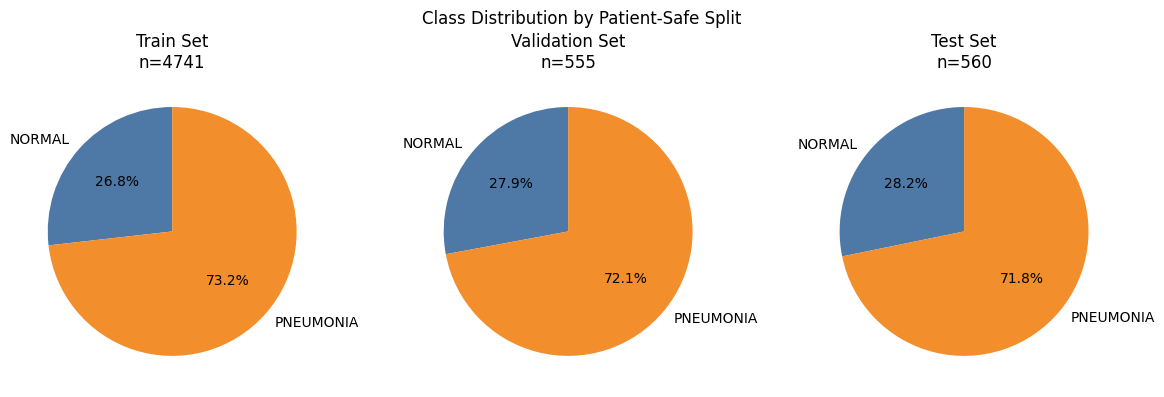

In [8]:
split_datasets = {
    "Train": train_dataset,
    "Validation": val_dataset,
    "Test": test_dataset,
}
class_names = ["NORMAL", "PNEUMONIA"]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for idx, (split_name, dataset) in enumerate(split_datasets.items()):
    labels = np.array(dataset.labels)
    counts = np.bincount(labels, minlength=2)
    ax = axes[idx]
    ax.pie(
        counts,
        labels=class_names,
        autopct="%1.1f%%",
        startangle=90,
        colors=["#4e79a7", "#f28e2b"],
    )
    ax.set_title(f"{split_name} Set\nn={counts.sum()}")

plt.suptitle("Class Distribution by Patient-Safe Split")
plt.tight_layout()
plt.show()

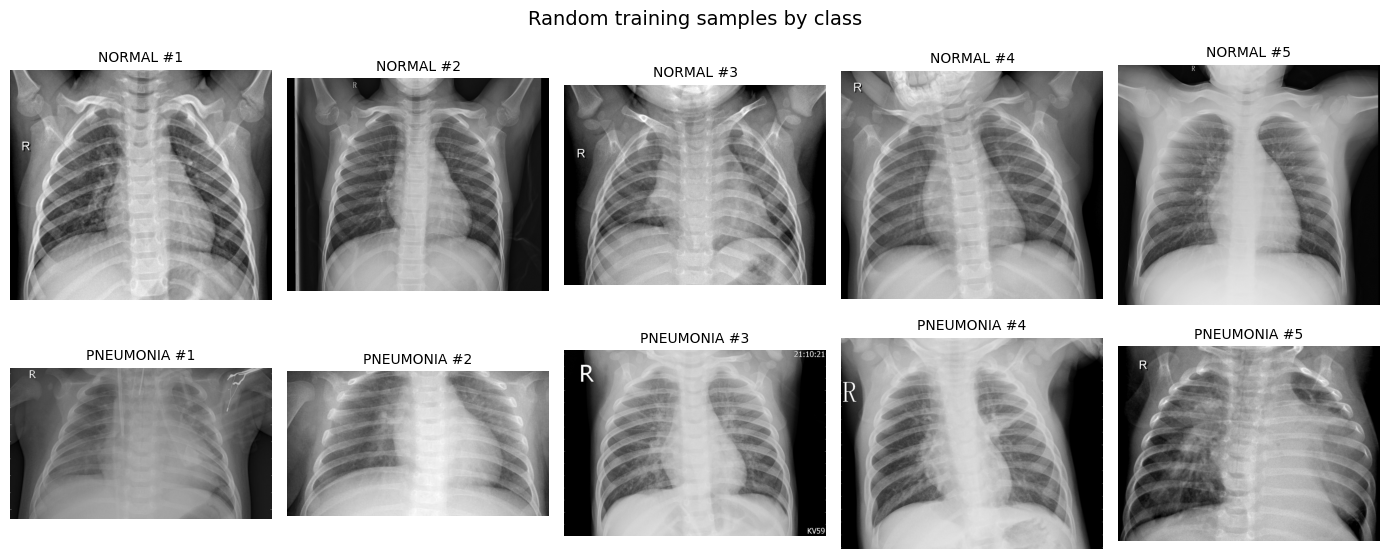

In [9]:
rng = np.random.default_rng(SEED)
labels_array = np.array(train_dataset.labels)

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for row, label in enumerate([0, 1]):
    indices = np.where(labels_array == label)[0]
    chosen = rng.choice(indices, size=min(5, len(indices)), replace=False)

    for col in range(5):
        ax = axes[row, col]
        ax.axis("off")

        if col >= len(chosen):
            continue

        idx = chosen[col]
        with Image.open(train_dataset.records[idx]["image_path"]) as img:
            ax.imshow(img.convert("L"), cmap="gray")

        ax.set_title(f"{class_names[label]} #{col + 1}", fontsize=10)

fig.suptitle("Random training samples by class", fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
# Class-weighted loss only (no weighted sampler) to avoid double correction.
train_labels = np.array(train_dataset.labels)
class_counts = np.bincount(train_labels)
class_weights = len(train_labels) / (2.0 * class_counts)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=(device.type != "cpu"),
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=(device.type != "cpu"),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=(device.type != "cpu"),
)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print(f"Class distribution (train): Normal={class_counts[0]}, Pneumonia={class_counts[1]}")
print(f"Class weights: {class_weights}")


Train: 4741 | Val: 555 | Test: 560
Class distribution (train): Normal=1270, Pneumonia=3471
Class weights: [1.86653543 0.6829444 ]


## Model

In [ ]:
# Freeze early layers, fine-tune later ones
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer3, layer4, and fc
for name, param in model.named_parameters():
    if any(s in name for s in ["layer3", "layer4", "fc"]):
        param.requires_grad = True

model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(model.fc.in_features, 2))
model.to(device)

In [12]:
# Loss with class weights + Optimizer + Scheduler
weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=1e-4
)

# Use a threshold-independent validation objective for LR scheduling and checkpointing.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2
)

## Training

In [13]:
def safe_auc_roc(y_true, y_prob):
    return roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float("nan")


def safe_auc_pr(y_true, y_prob):
    return average_precision_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float("nan")


best_val_metric = -np.inf
best_model_state = copy.deepcopy(model.state_dict())
best_val_labels = None
best_val_probs = None
epochs_no_improve = 0
history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / max(1, len(train_loader))

    model.eval()
    val_labels_list, val_probs_list = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            val_labels_list.extend(labels.cpu().numpy())
            val_probs_list.extend(probs.cpu().numpy())

    y_val = np.array(val_labels_list)
    p_val = np.array(val_probs_list)
    y_val_pred_05 = (p_val >= 0.5).astype(int)

    val_acc = accuracy_score(y_val, y_val_pred_05)
    val_f1 = f1_score(y_val, y_val_pred_05, zero_division=0)
    val_auc_pr = safe_auc_pr(y_val, p_val)
    val_auc_roc = safe_auc_roc(y_val, p_val)

    val_metric = val_auc_pr if not np.isnan(val_auc_pr) else val_acc
    scheduler.step(val_metric)

    history.append(
        {
            "epoch": epoch + 1,
            "train_loss": float(avg_loss),
            "val_acc_at_0.5": float(val_acc),
            "val_f1_at_0.5": float(val_f1),
            "val_auc_pr": None if np.isnan(val_auc_pr) else float(val_auc_pr),
            "val_auc_roc": None if np.isnan(val_auc_roc) else float(val_auc_roc),
            "val_metric": float(val_metric),
            "lr": float(optimizer.param_groups[0]["lr"]),
        }
    )

    print(
        f"Epoch {epoch + 1}/{EPOCHS} | Loss: {avg_loss:.4f} | "
        f"Val AUPRC: {val_auc_pr:.4f} | Val AUROC: {val_auc_roc:.4f} | "
        f"Val Acc@0.5: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}"
    )

    if val_metric > best_val_metric + 1e-8:
        best_val_metric = val_metric
        best_model_state = copy.deepcopy(model.state_dict())
        best_val_labels = y_val.copy()
        best_val_probs = p_val.copy()
        epochs_no_improve = 0
        print(f"  -> New best model saved (val_metric={val_metric:.4f})")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch + 1}")
            break

if best_model_state is None:
    raise RuntimeError("best_model_state was not set. Training checkpointing failed.")

Epoch 1/20: 100%|██████████| 149/149 [02:04<00:00,  1.20it/s]


Epoch 1/20 | Loss: 0.1971 | Val AUPRC: 0.9972 | Val AUROC: 0.9925 | Val Acc@0.5: 0.9279 | LR: 0.000100
  -> New best model saved (val_metric=0.9972)


Epoch 2/20: 100%|██████████| 149/149 [01:42<00:00,  1.46it/s]


Epoch 2/20 | Loss: 0.1365 | Val AUPRC: 0.9975 | Val AUROC: 0.9937 | Val Acc@0.5: 0.9225 | LR: 0.000100
  -> New best model saved (val_metric=0.9975)


Epoch 3/20: 100%|██████████| 149/149 [01:44<00:00,  1.43it/s]


Epoch 3/20 | Loss: 0.1082 | Val AUPRC: 0.9982 | Val AUROC: 0.9955 | Val Acc@0.5: 0.9640 | LR: 0.000100
  -> New best model saved (val_metric=0.9982)


Epoch 4/20: 100%|██████████| 149/149 [01:43<00:00,  1.44it/s]


Epoch 4/20 | Loss: 0.0935 | Val AUPRC: 0.9987 | Val AUROC: 0.9966 | Val Acc@0.5: 0.9532 | LR: 0.000100
  -> New best model saved (val_metric=0.9987)


Epoch 5/20: 100%|██████████| 149/149 [01:43<00:00,  1.44it/s]


Epoch 5/20 | Loss: 0.0808 | Val AUPRC: 0.9986 | Val AUROC: 0.9963 | Val Acc@0.5: 0.9676 | LR: 0.000100


Epoch 6/20: 100%|██████████| 149/149 [01:43<00:00,  1.44it/s]


Epoch 6/20 | Loss: 0.0832 | Val AUPRC: 0.9990 | Val AUROC: 0.9974 | Val Acc@0.5: 0.9207 | LR: 0.000100
  -> New best model saved (val_metric=0.9990)


Epoch 7/20: 100%|██████████| 149/149 [01:44<00:00,  1.43it/s]


Epoch 7/20 | Loss: 0.0702 | Val AUPRC: 0.9986 | Val AUROC: 0.9965 | Val Acc@0.5: 0.9766 | LR: 0.000100


Epoch 8/20: 100%|██████████| 149/149 [01:43<00:00,  1.44it/s]


Epoch 8/20 | Loss: 0.0770 | Val AUPRC: 0.9983 | Val AUROC: 0.9953 | Val Acc@0.5: 0.9297 | LR: 0.000100


Epoch 9/20: 100%|██████████| 149/149 [01:44<00:00,  1.42it/s]


Epoch 9/20 | Loss: 0.0738 | Val AUPRC: 0.9982 | Val AUROC: 0.9950 | Val Acc@0.5: 0.9568 | LR: 0.000050


Epoch 10/20: 100%|██████████| 149/149 [01:41<00:00,  1.47it/s]


Epoch 10/20 | Loss: 0.0523 | Val AUPRC: 0.9985 | Val AUROC: 0.9958 | Val Acc@0.5: 0.9550 | LR: 0.000050


Epoch 11/20: 100%|██████████| 149/149 [01:40<00:00,  1.48it/s]


Epoch 11/20 | Loss: 0.0594 | Val AUPRC: 0.9984 | Val AUROC: 0.9955 | Val Acc@0.5: 0.9477 | LR: 0.000050
Early stopping at epoch 11


In [17]:
# Helper metrics + threshold selection
def safe_auc_roc(y_true, y_prob):
    return roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float("nan")

def safe_auc_pr(y_true, y_prob):
    return average_precision_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float("nan")

def confusion_elements(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn, fp, fn, tp

def threshold_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_elements(y_true, y_pred)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "ppv": ppv,
        "npv": npv,
    }

def choose_threshold(y_true, y_prob, target_sensitivity=0.95):
    thresholds = np.linspace(0.0, 1.0, 1001)
    candidates = []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        m = threshold_metrics(y_true, y_pred)
        candidates.append((float(t), m))

    feasible = [x for x in candidates if x[1]["sensitivity"] >= target_sensitivity]
    if feasible:
        best_t, best_m = max(feasible, key=lambda x: (x[1]["f1"], x[1]["specificity"]))
        policy = "sensitivity_constrained"
    else:
        best_t, best_m = max(candidates, key=lambda x: (x[1]["f1"], x[1]["sensitivity"]))
        policy = "f1_fallback"
    return best_t, best_m, policy

def bootstrap_cis(y_true, y_prob, threshold, n_boot=500, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    stats = {k: [] for k in ["accuracy","f1","sensitivity","specificity","ppv","npv","roc_auc","pr_auc"]}

    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        y_b = y_true[idx]
        p_b = y_prob[idx]
        y_pred_b = (p_b >= threshold).astype(int)

        m = threshold_metrics(y_b, y_pred_b)
        for k in ["accuracy","f1","sensitivity","specificity","ppv","npv"]:
            stats[k].append(m[k])

        if len(np.unique(y_b)) > 1:
            stats["roc_auc"].append(roc_auc_score(y_b, p_b))
            stats["pr_auc"].append(average_precision_score(y_b, p_b))

    cis = {}
    for k, vals in stats.items():
        if len(vals) == 0:
            cis[k] = {"lower": None, "upper": None}
        else:
            lo, hi = np.percentile(vals, [2.5, 97.5])
            cis[k] = {"lower": float(lo), "upper": float(hi)}
    return cis


In [18]:
# Collect validation/test logits from best checkpoint
model.load_state_dict(best_model_state)
model.eval()

def collect_logits_labels(loader, model, device):
    all_logits, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            logits = model(images)
            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())
    return torch.cat(all_logits, dim=0), torch.cat(all_labels, dim=0)

val_logits_t, val_labels_t = collect_logits_labels(val_loader, model, device)
test_logits_t, test_labels_t = collect_logits_labels(test_loader, model, device)

print("val logits:", tuple(val_logits_t.shape), "test logits:", tuple(test_logits_t.shape))


val logits: (555, 2) test logits: (560, 2)


In [19]:
# Fit temperature on validation set
def fit_temperature(val_logits, val_labels, max_iter=200):
    # optimize log(T) so T stays positive
    log_t = torch.nn.Parameter(torch.zeros(1))
    nll = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.LBFGS(
        [log_t], lr=0.1, max_iter=max_iter, line_search_fn="strong_wolfe"
    )

    def closure():
        optimizer.zero_grad()
        t = torch.exp(log_t).clamp(1e-3, 100.0)
        loss = nll(val_logits / t, val_labels)
        loss.backward()
        return loss

    optimizer.step(closure)
    T = float(torch.exp(log_t).clamp(1e-3, 100.0).item())
    return T

temperature = fit_temperature(val_logits_t, val_labels_t)
print(f"Learned temperature: {temperature:.6f}")

# quick calibration sanity check on validation NLL/Brier
val_prob_raw = torch.softmax(val_logits_t, dim=1)[:, 1].numpy()
val_prob_cal = torch.softmax(val_logits_t / temperature, dim=1)[:, 1].numpy()
val_y = val_labels_t.numpy()

val_nll_raw = F.cross_entropy(val_logits_t, val_labels_t).item()
val_nll_cal = F.cross_entropy(val_logits_t / temperature, val_labels_t).item()
val_brier_raw = brier_score_loss(val_y, val_prob_raw)
val_brier_cal = brier_score_loss(val_y, val_prob_cal)

print(f"Val NLL raw/cal:   {val_nll_raw:.6f} -> {val_nll_cal:.6f}")
print(f"Val Brier raw/cal: {val_brier_raw:.6f} -> {val_brier_cal:.6f}")

Learned temperature: 1.912755
Val NLL raw/cal:   0.221162 -> 0.181493
Val Brier raw/cal: 0.060714 -> 0.056551


## Evaluation

In [20]:
# Use calibrated validation probabilities for threshold selection
best_val_labels = val_labels_t.numpy()
best_val_probs = torch.softmax(val_logits_t / temperature, dim=1)[:, 1].numpy()

selected_threshold, val_threshold_metrics, threshold_policy = choose_threshold(
    best_val_labels,
    best_val_probs,
    target_sensitivity=TARGET_SENSITIVITY,
)

print(f"Selected threshold: {selected_threshold:.3f} (policy={threshold_policy})")
print(f"Validation metrics at selected threshold: {val_threshold_metrics}")

# Evaluate on calibrated test probabilities
y_true = test_labels_t.numpy()
y_prob = torch.softmax(test_logits_t / temperature, dim=1)[:, 1].numpy()
y_pred = (y_prob >= selected_threshold).astype(int)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc_roc = safe_auc_roc(y_true, y_prob)
auc_pr = safe_auc_pr(y_true, y_prob)
brier = brier_score_loss(y_true, y_prob)
thr = threshold_metrics(y_true, y_pred)
ci = bootstrap_cis(y_true, y_prob, selected_threshold, n_boot=500, seed=SEED)

print("\nTest set performance (calibrated)")
print(f"Threshold: {selected_threshold:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 score: {f1:.4f}")
print(f"Sensitivity: {thr['sensitivity']:.4f}")
print(f"Specificity: {thr['specificity']:.4f}")
print(f"PPV: {thr['ppv']:.4f}")
print(f"NPV: {thr['npv']:.4f}")
print(f"ROC-AUC:  {auc_roc:.4f}")
print(f"PR-AUC:   {auc_pr:.4f}")
print(f"Brier:    {brier:.4f}")

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA'], zero_division=0))

print("\n95% bootstrap CI:")
for k, v in ci.items():
    print(f"{k}: {v}")


Selected threshold: 0.059 (policy=sensitivity_constrained)
Validation metrics at selected threshold: {'accuracy': 0.9819819819819819, 'f1': 0.9875930521091811, 'sensitivity': np.float64(0.995), 'specificity': np.float64(0.9483870967741935), 'ppv': np.float64(0.9802955665024631), 'npv': np.float64(0.9865771812080537)}

Test set performance (calibrated)
Threshold: 0.0590
Accuracy: 0.9679
F1 score: 0.9777
Sensitivity: 0.9826
Specificity: 0.9304
PPV: 0.9729
NPV: 0.9545
ROC-AUC:  0.9938
PR-AUC:   0.9976
Brier:    0.0625

Classification report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.93      0.94       158
   PNEUMONIA       0.97      0.98      0.98       402

    accuracy                           0.97       560
   macro avg       0.96      0.96      0.96       560
weighted avg       0.97      0.97      0.97       560


95% bootstrap CI:
accuracy: {'lower': 0.9517857142857142, 'upper': 0.9821428571428571}
f1: {'lower': 0.9658969706921923, 'upper

### Plots

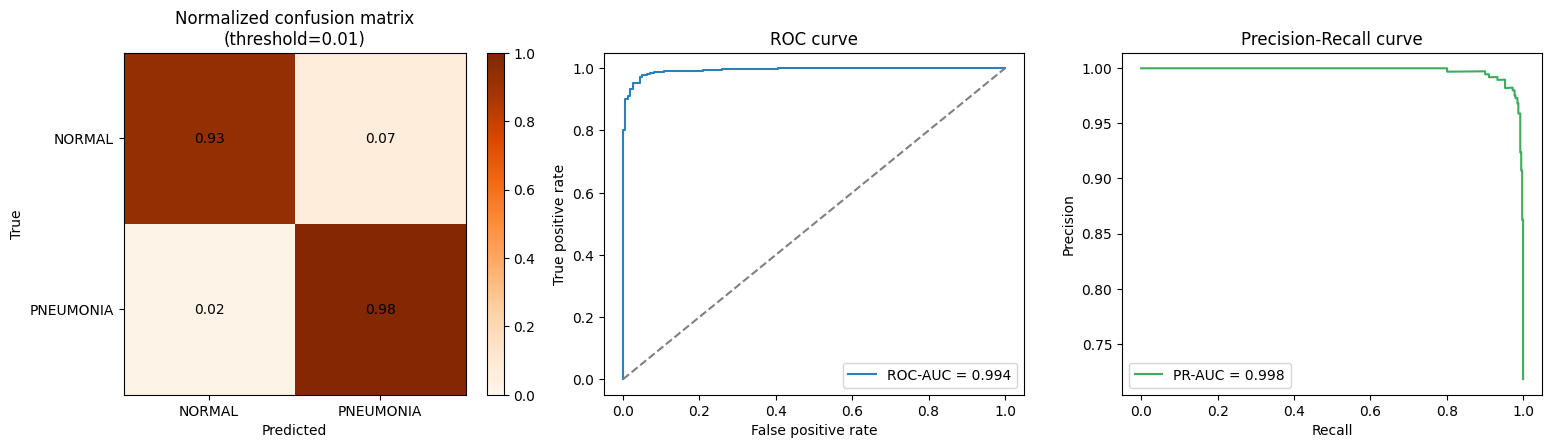

In [15]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_prob)
cm_norm = confusion_matrix(y_true, y_pred, normalize="true")

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

im = axes[0].imshow(cm_norm, cmap="Oranges", vmin=0, vmax=1)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        axes[0].text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center", color="black")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(["NORMAL", "PNEUMONIA"])
axes[0].set_yticklabels(["NORMAL", "PNEUMONIA"])
axes[0].set_title(f"Normalized confusion matrix\n(threshold={selected_threshold:.2f})")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
fig.colorbar(im, ax=axes[0], fraction=0.046)

axes[1].plot(fpr, tpr, label=f"ROC-AUC = {auc_roc:.3f}", color="#2C7FB8")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[1].set_title("ROC curve")
axes[1].set_xlabel("False positive rate")
axes[1].set_ylabel("True positive rate")
axes[1].legend(loc="lower right")

axes[2].plot(recall_curve, precision_curve, label=f"PR-AUC = {auc_pr:.3f}", color="#41AB5D")
axes[2].set_title("Precision-Recall curve")
axes[2].set_xlabel("Recall")
axes[2].set_ylabel("Precision")
axes[2].legend(loc="lower left")

plt.tight_layout()
plt.show()

## Save model

In [16]:
MODEL_DIR.mkdir(parents=True, exist_ok=True)

model_path = MODEL_DIR / "model.pth"
torch.save(model.state_dict(), model_path)
print(f"Saved model to: {model_path}")

Saved model to: models/model.pth
